# BERT text classification on movie dataset

In this notebook, we will use Hugging face [Transformers](https://huggingface.co/transformers/) to build BERT model on text classification task with [Tensorflow 2.0](https://www.tensorflow.org/guide/effective_tf2). 

Notes: this notebook is entirely run on [Google colab](https://colab.research.google.com/) with GPU. If you start a new notebook, you need to choose "Runtime"->"Change runtime type" ->"GPU" at the begining.

### Introduction of BERT

[BERT](https://https://arxiv.org/abs/1810.04805)  ( which stands for Bidirectional Encoder Representations from
Transformers) as a languge model was introduced by Jacob et. al. at 2018 from Google. BERT is designed to pretrain deep bidirectional representations from unlabeled text by jointly conditioning on both left and right context in all layers. 

The core of BERT is tranformer. For those who don't know what is transoformer, ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) and this [blog](https://mchromiak.github.io/articles/2017/Sep/12/Transformer-Attention-is-all-you-need/#.Xk1qTChKhPb) are good resources to get an ideal how attention mechanism works and how transformer works.



### Introduction of huggingface or Transformers

Hugging face is a company which invented a pacakge called [Transformers](https://github.com/huggingface/transformers). It provides state-of-the-art general-purpose architectures (BERT, GPT-2, RoBERTa, XLM, DistilBert, XLNet, CTRL...) for Natural Language Understanding (NLU) and Natural Language Generation (NLG) with over 32+ pretrained models in 100+ languages and deep interoperability between TensorFlow 2.0 and PyTorch.

TensorFlow uses layers of abstraction when putting together a model. Operations (such as matrix algebra) can occur at a low level, and an abstraction of a neural network layer can occur at a higher level. One of these higher levels of abstraction is called a Keras model, and Huggingface uses this model as a way to abstract some of the granular details involved in using BERT for transfer learning.

The Transformer is mainly developed based on the pytorch but the TensorFLow 2.0 version implementation on BERT is also fantasic. I am a fan of tensorflow, so in this notebook, we will implement a classification task using Transformers with TF 2.0.

# Run BERT

Before we will start taking about the model and data, we need setup packages in Google colab.   
So we need to upgrade **pip**, install **tensorflow-gpu 2.0** and **transformers**. It takes about 1 min to run. You may notice here, I use tensorflow-gpu instead of tensorflow, becuase bert use a lot of computation resources, gpu will run much faster than cpu. The good thing is, you only need the gpu package installed. All other operations are same in regular tensorflow. The TF infrastructure will handle it. 

## Install package

In [1]:
!pip install -q --upgrade pip
!pip install -q tensorflow-gpu==2.0.0
!pip install -q transformers

     |████████████████████████████████| 1.4MB 15.4MB/s 
     |████████████████████████████████| 380.8 MB 38 kB/s 
     |████████████████████████████████| 449 kB 49.6 MB/s 
     |████████████████████████████████| 3.8 MB 66.3 MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
     |████████████████████████████████| 475 kB 22.8 MB/s 
     |████████████████████████████████| 1.0 MB 56.0 MB/s 
     |████████████████████████████████| 860 kB 104.8 MB/s 
     |████████████████████████████████| 3.1 MB 76.9 MB/s 


## Prepare dataset

### Download data

In this example , we will use standford movie review sentiment analysis data, it has been upload on [Kaggle](https://www.kaggle.com/atulanandjha/imdb-50k-movie-reviews-test-your-bert). It contian 25000 train and 25000 test review texts and labels as 'pos' and 'neg', which has been anotaited their sentiments. Task is to use text to build claissifier to identify it's sentiment.  I have downloaded it and upload into my repo.

In [2]:
!git clone https://github.com/yuyongze/movie-sst2.git
%cd movie-sst2

Cloning into 'movie-sst2'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
/content/movie-sst2


### Load data

In [0]:
import tensorflow as tf
import pandas as pd
from tensorflow.python.lib.io.tf_record import TFRecordWriter

Read csv file, we notice that the sentiment is labeled as 'pos' and 'neg', we replace the 'pos' as 1 and 'neg' as 0,
And inthis example, we are using only 20% data (**5000 examples**) as a toy example to demonstrate the model can work well. 

In [0]:
# fraction of sample pass to the train and test as example
SAMPLE_FRAC = 0.2
# 80% data for training and 20% data for validate
TRAIN_FRAC = 0.8
# load train data from train.csv
train = pd.read_csv('./data/train.csv')
train.reset_index(inplace=True)
# change sentiment label form 'pos' and 'neg' to 1 and 0, which bert model knows
train['sentiment'].replace({'pos':1,'neg':0},inplace=True)

# train set
train_sample = train.sample(frac=SAMPLE_FRAC,random_state=0)
train_select = train_sample.sample(frac= TRAIN_FRAC,random_state=0)
train_csv = train_select.values

# validate set 
validate_select = train_sample.drop(index=train_select.index)
validate_csv = validate_select.values


# load test data , here should be validation set
test = pd.read_csv('./data/test.csv')
test.reset_index(inplace=True)
test['sentiment'].replace({'pos':1,'neg':0},inplace=True)
test_csv = test.sample(frac=SAMPLE_FRAC,random_state=0).values

In [42]:
train.tail()

,index,text,sentiment
24995,24995,"This film is fun, if your a person who likes a...",1
24996,24996,After seeing this film I feel like I know just...,1
24997,24997,first this deserves about 5 stars due to actin...,0
24998,24998,If you like films that ramble with little plot...,0
24999,24999,"As interesting as a sheet of cardboard, this d...",0


As you can see the *train_csv*,*validate_csv*, and *test_csv* has 3 columns, which are 'index','text',and 'sentiment'. They are important, becuase we need to pack those three parts into examples and feed to the models.

### Build TFRecord

We have training data and validate data ready, and now we need convert those data into [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) which tensorflow can read it into tf.data.Dataset object easily. In this [guide](https://www.tensorflow.org/guide/data), you can find how to transfer data into `tf.data.Dataset`.

In [0]:
import time
def create_tf_example(features,label):
    """
    Create tf example using features and label

    Args:
        features: list, feature list with format  ['idx','sentence']
        label: string, 

    Return:
        A binary-string of tf example.
        All proto messages can be serialized to a binary-string using the .SerializeToString method.
    """
    tf_example = tf.train.Example(features = tf.train.Features(feature = {
        'idx': tf.train.Feature(int64_list=tf.train.Int64List(value=[features[0]])),
        'sentence': tf.train.Feature(bytes_list=tf.train.BytesList(value=[features[1].encode('utf-8')])),
        'label': tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }))
    return tf_example.SerializeToString()

def convert_csv_to_tfrecord(csv, file_name):
    """
    Convert the numpy arryes to tfrecord and write files

    Args:
        csv: numpy arrays, each row feed (features+label)
        file_name: location TFRecord to be saved 
    """
    start_time = time.time()
    writer = TFRecordWriter(file_name)
    for idx,row in enumerate(csv):
        # check the row retionality, raise error when missing value
        try:
            if row is None:
                raise Exception('Row Missing')
            if row[0] is None or row[1] is None or row[2] is None:
                raise Exception('Value Missing')
            if row[1].strip() is '':
                raise Exception('Utterance is empty')
            
            features, label = row[:-1],row[-1]
            example =  create_tf_example(features,label)
            writer.write(example)

        except Exception as inst:
            print(type(inst))
            print(inst.args)
            print(inst)
    writer.close()
    print(f"{file_name}: --- {(time.time() - start_time)} seconds ---")

convert csv(numpy files) to tfrecord using `convert_csv_to_tfrecord`

In [137]:
convert_csv_to_tfrecord(train_csv, "./data/movie_train.tfrecord")
convert_csv_to_tfrecord(validate_csv, "./data/movie_validate.tfrecord")
convert_csv_to_tfrecord(test_csv, "./data/movie_test.tfrecord")

./data/movie_train.tfrecord: --- 0.16509032249450684 seconds ---
data/movie_validate.tfrecord: --- 0.04649686813354492 seconds ---
data/movie_test.tfrecord: --- 0.19834470748901367 seconds ---


now we will generate a json file to save number of training example to determine the tranin steps in the later process

In [0]:
import json
# generate exmaple number , save for use in the future 
def generate_json_info(local_file_name,df_train=[],df_val=[],df_test=[]):
    info = {"train_length": len(df_train), "validation_length": len(df_val),
            "test_length": len(df_test)}

    with open(local_file_name, 'w') as outfile:
        json.dump(info, outfile)

generate_json_info('./data/info.json',train_csv,validate_csv,test_csv)

#### Confirm that TFRecord has encoded correctly

In [0]:
tr_ds = tf.data.TFRecordDataset("data/movie_train.tfrecord")

About how to write and read tensorflow TFRecord, you can read documentation [here](https://www.tensorflow.org/tutorials/load_data/tfrecord).

In [0]:
# Create a description of the features.
feature_spec = {
    'idx': tf.io.FixedLenFeature([], tf.int64),
    'sentence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}
def parse_example(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_spec)
tr_parse_ds = tr_ds.map(parse_example)
dataset_iterator = iter(tr_parse_ds)

In [141]:
dataset_iterator.get_next()

{'idx': <tf.Tensor: id=259301, shape=(), dtype=int64, numpy=8383>,
 'label': <tf.Tensor: id=259302, shape=(), dtype=int64, numpy=1>,
 'sentence': <tf.Tensor: id=259303, shape=(), dtype=string, numpy=b"This movie is difficult to watch in our fast-paced culture of the 21st century, but it is worth it for the messages that it conveys, chiefly the consequences and ramifications of technology upon society, specifically when that technology is used for warfare.<br /><br />This movie presents a full circle cycle of dehumanization and rehumanization as influenced by the advent of technology and the subsequent deconstruction of civilization and therefore serves as a cautionary tale against the misuse of technology, but as the circle completes itself, familiar themes and sentiments pop up again to present self-serving rather than self-destructive ways that humanity may utilize technology.<br /><br />Brilliant for it's time, the picture and sound quality may pose a challenge for some, but as a la

## BERT Sentiment Classification in TensorFlow 2.0

In [0]:
import tensorflow as tf
from transformers import *
from transformers import BertTokenizer, TFBertForSequenceClassification, glue_convert_examples_to_features
from transformers.configuration_bert import BertConfig

Load the TFRecord

In [0]:
tr_ds = tf.data.TFRecordDataset("data/movie_train.tfrecord")
val_ds = tf.data.TFRecordDataset("data/movie_validate.tfrecord")
test_ds = tf.data.TFRecordDataset("data/movie_test.tfrecord")


In [0]:
# Create a description of the features.
feature_spec = {
    'idx': tf.io.FixedLenFeature([], tf.int64),
    'sentence': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64)
}
def parse_example(example_proto):
  # Parse the input tf.Example proto using the dictionary above.
    return tf.io.parse_single_example(example_proto, feature_spec)

# convert the encoded string tensor into the separate tensors that will feed into the model
tr_parse_ds = tr_ds.map(parse_example)
val_parse_ds = val_ds.map(parse_example)
test_parse_ds =  test_ds.map(parse_example)

One approach to cleaning up a pipeline is to map a function to the dataset. In this way, the function gets applied to each example. The following code uses this approach to clean up the sentence tensor.



In [0]:
def clean_string(features):
    revised_sentence = tf.strings.regex_replace(features['sentence'], "\.\.\.", "", replace_global=True)
    revised_sentence = tf.strings.regex_replace(revised_sentence, "\\'", "'", replace_global=True)
    revised_sentence = tf.strings.regex_replace(revised_sentence, "\\n", "", replace_global=True)
    features['sentence'] = revised_sentence
    return features

In [0]:
tr_clean_ds = tr_parse_ds.map(lambda features: clean_string(features))
val_clean_ds = val_parse_ds.map(lambda features: clean_string(features))
test_clean_ds =  test_parse_ds.map(lambda features: clean_string(features))

### Train

Before training, we need to set up some paramerter ahead. `BATCH_SIZE`=8 here, it is because in google colab, it will run into a memory issue with bert model at max_length = 512. Usually, the batch_size can be set as 32. USE_XLA and USE_AMP are two methods to help the train speed, in this notebook, we will not discuss that. Therefore, we set them to False.

In [0]:
BATCH_SIZE = 8

EVAL_BATCH_SIZE = BATCH_SIZE * 2

# XLA is the optimizing compiler for machine learning
# It can potentially increase speed by 15% with no source code changes
USE_XLA = False

# mixed precision results on https://github.com/huggingface/transformers/tree/master/examples
# Mixed precision can help to speed up training time
USE_AMP = False

In [0]:
tf.config.optimizer.set_jit(USE_XLA)
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": USE_AMP})

In [13]:
# Steps is determined by the number of examples
import json
with open('data/info.json') as json_file:
    data_info = json.load(json_file)
    
train_examples = data_info['train_length']
valid_examples = data_info['validation_length']
test_examples = data_info['test_length']

train_examples, valid_examples, test_examples

(4000, 1000, 5000)

Now that we have a pipeline setup, we need to start the process of converting words into numbers so that they can be processed by the BERT transfer learning backbone. This process is commonly called Tokenization, and Huggingface includes a tokenizer that helps with this process.

The tokenizers are based on the underlying research code. For example, the following are different BERT models that can be utilized within the BERT framework:

* ``bert-base-uncased``: 12-layer, 768-hidden, 12-heads, 110M parameters
* ``bert-large-uncased``: 24-layer, 1024-hidden, 16-heads, 340M parameters
* ``bert-base-cased``: 12-layer, 768-hidden, 12-heads , 110M parameters
* ``bert-large-cased``: 24-layer, 1024-hidden, 16-heads, 340M parameters

As seen above, the different numbers have different levels of complexity and are associated either with uncapitalized text (uncased) or text that has capitalization. I selected the bert-base-cased underlying model because the movie text have capitalization. I also selected it because in general models that are less complex tend to run faster than models which are more complex.

The Transformers framework can use a configuration dictionary in order to set up the hyperparameters for the model. In this case, I explictly use the config to make sure that the model is looking at num_labels=2. If we had been going through an example with three categories ('Positive', 'Negative', and 'Neutral') as opposed to just two cases ('Positive' and 'Negative') then we would have wanted to use num_labels=3 instead. [Ref](https://github.com/huggingface/transformers/blob/master/examples/run_tf_glue.py)

In [0]:
# Load tokenizer and model from pretrained model/vocabulary. Specify the number of labels to classify (2+: classification, 1: regression)
num_labels = 2 
config = BertConfig.from_pretrained("bert-base-cased", num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")
model = TFBertForSequenceClassification.from_pretrained('bert-base-cased', config=config)

In [0]:
# Make use of the following config parameters

# {
#   "architectures": [
#     "BertForMaskedLM"
#   ],
#   "attention_probs_dropout_prob": 0.1,
#   "hidden_act": "gelu",
#   "hidden_dropout_prob": 0.1,
#   "hidden_size": 768,
#   "initializer_range": 0.02,
#   "intermediate_size": 3072,
#   "max_position_embeddings": 512,
#   "num_attention_heads": 12,
#   "num_hidden_layers": 12,
#   "type_vocab_size": 2,
#   "vocab_size": 28996
# }

Now that we have a tokenizer and the model with the right configurations, we need to take our parsed tensors (the tr_parse_ds or train parsed dataset) and feed them into the Huggingface framework. To do this, we are going to make a slight modification to the glue_convert_examples_to_features code found in the HuggingFace transformers repo. Here we are going to use the sst-2 task (the Stanford Sentiment Treebank binary classification task) because this task also works with binary classification. 

Notes:

Huggingface uses the similar strategy of taking the TFExamples and using a dataset in order to convert the "sentence" and "labels" into inputs that are needed by BERT (inputs such as 'input_ids', 'attention_mask', and 'token_type_ids'). As disscussed earlier in the workbook, this transformation process makes it quick to test out the conversion on a couple of data points and to move onto the next step without waiting for the full conversion to complete.

In [69]:
import time
start_time = time.time()
train_dataset = glue_convert_examples_to_features(examples=tr_clean_ds, tokenizer=tokenizer
                                                  , max_length=512, task='sst-2',
                                                  label_list=['0','1']
                                                  )
print(f"---{time.time()-start_time} seconds---")

---14.97620701789856 seconds---


In [70]:
import time
start_time = time.time()
valid_dataset = glue_convert_examples_to_features(examples=val_clean_ds, tokenizer=tokenizer
                                                  , max_length=512, task='sst-2'
                                                  , label_list =['0', '1'])
print(f"---{time.time()-start_time} seconds---")

---3.7171196937561035 seconds---


In [0]:
train_dataset = train_dataset.shuffle(train_examples).batch(BATCH_SIZE).repeat(-1)

valid_dataset = valid_dataset.batch(EVAL_BATCH_SIZE)

In this next section, we need to configure the loss function, the optimizer, and any additional metrics that we want to capture.

Loss:

This is the objective that the model is trying to minimize. In our example, the HuggingFace framework compares this against the distribution of predicted classes. Said differently, we are trying to compare how similar the actual distribution is to the predicted distribution, and this is captured in the loss function called SparseCategoricalCrossentropy .

A good discussion on cross entropy can be found at The Gradient

Optimizer:

Deep learning is the process of minimizing a loss function. The process that determines what steps to try out in each iteration is commonly referred to as the optimizer. For this exercise, I used the Adam optimization algorithm which tends to work well in a variety of situations.

Metric:

As a basic metric, we should look at the number of times that the actual class is identical to what is predicted.

Unfortunately ,the model currently generates unscaled outputs for each example (an unscaled output for the negative class and another unscaled output for the positive class). Said differently, the model generates outputs before they are converted into probabilities (the conversion happens with a softmax function). Because of all of this, the appropriate metric to use would be SparseCategoricalAccuracy.

In [0]:
opt = tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08)

if USE_AMP:
    # loss scaling is currently required when using mixed precision
    opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, 'dynamic')

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=opt, loss=loss, metrics=[metric])

The TensorFlow documentation states the following:

**If x is a tf.data dataset, and 'steps_per_epoch' is None, the epoch will run until the input dataset is exhausted.**

Because these datasets can be a precursor to training on TFRecords of significant size, it is best practice to specificially state the number of steps that will be processed per epoch in the train and validation stage.

In [0]:
train_steps = train_examples//BATCH_SIZE
valid_steps = valid_examples//EVAL_BATCH_SIZE

GPUs run up to 27x faster that CPUs for model training. Because of this, it is critical that the following preconditions are in place:

You are using the version of Tensflow for GPUs
The code has access to a GPU
To confirm the preconditions, I run the following code to detect GPUs and to see the physical devices that are available.

In [76]:
# GPU USAGE
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices()

Num GPUs Available:  1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [77]:
model.summary()

Model: "tf_bert_for_sequence_classification_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
_________________________________________________________________
dropout_75 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  1538      
Total params: 108,311,810
Trainable params: 108,311,810
Non-trainable params: 0
_________________________________________________________________


In [78]:
history = model.fit(train_dataset, epochs=3, steps_per_epoch=train_steps,
                    validation_data=valid_dataset, validation_steps=valid_steps)

Train for 500 steps, validate for 62 steps
Epoch 1/3
500/500 [==============================] - 561s 1s/step - loss: 0.4208 - accuracy: 0.7883 - val_loss: 0.2677 - val_accuracy: 0.8942
Epoch 2/3
500/500 [==============================] - 543s 1s/step - loss: 0.2023 - accuracy: 0.9268 - val_loss: 0.2334 - val_accuracy: 0.9133
Epoch 3/3
500/500 [==============================] - 542s 1s/step - loss: 0.1015 - accuracy: 0.9672 - val_loss: 0.2833 - val_accuracy: 0.9103


Train for 500 steps, validate for 62 steps
Epoch 1/3
500/500 [==============================] - 561s 1s/step - loss: 0.4208 - accuracy: 0.7883 - val_loss: 0.2677 - val_accuracy: 0.8942
Epoch 2/3
500/500 [==============================] - 543s 1s/step - loss: 0.2023 - accuracy: 0.9268 - val_loss: 0.2334 - val_accuracy: 0.9133
Epoch 3/3
500/500 [==============================] - 542s 1s/step - loss: 0.1015 - accuracy: 0.9672 - val_loss: 0.2833 - val_accuracy: 0.9103

It tooks about 30mins to train 3 epochs on this setting. And we can acctich 0.91 accuracy on mini dev set.

### Evaluate the results of the model

In [79]:
import time
start_time = time.time()
test_dataset = glue_convert_examples_to_features(examples=test_clean_ds, tokenizer=tokenizer
                                                  , max_length=512, task='sst-2'
                                                  , label_list =['0', '1'])
print(f"---{time.time()-start_time} seconds---")

---19.080271005630493 seconds---


In [0]:
test_dataset = test_dataset.batch(EVAL_BATCH_SIZE)


In [81]:
model.evaluate(test_dataset)

63/63 [==============================] - 42s 667ms/step - loss: 0.2860 - accuracy: 0.9090


[0.2859640326868329, 0.909]

63/63 [==============================] - 42s 667ms/step - loss: 0.2860 - accuracy: 0.9090
[0.2859640326868329, 0.909]

As you can see, with only using the small sample size, we can acheive 0.909 accurarcy on test set. It was reported 0.935 in orginal BERT paper in this base model.  

### Create a Confusion Matrix

We can also visualize the evaluation in terms of how many true positives, true negatives, false positives, and false negatives occur. This visualization is commonly called a Confusion Matrix.

Creation of the confusion matrix involves the following steps:

1) Take the unnormalized outputs from the model (the logits) and compress them into probabilities (that by definition are between 0 and 1). The function that converts logits into probabilities is the softmax function.

2) Once you have probabilities for each prediction, identify predicted emotion ('Negative' or 'Positive') by selecting the probability with the largest value. This is accomplished with the argmax function.

In [0]:
y_pred = tf.nn.softmax(model.predict(test_dataset))

In [0]:
y_pred_argmax = tf.math.argmax(y_pred, axis=1)

In [0]:
y_true = tf.Variable([], dtype=tf.int64)

for features, label in test_dataset.take(-1):
    y_true = tf.concat([y_true, label], 0)

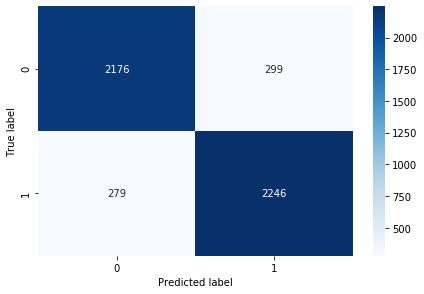

In [85]:
%matplotlib inline  
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

def visualize_confusion_matrix(y_pred_argmax, y_true):
    """

    :param y_pred_arg: This is an array with values that are 0 or 1
    :param y_true: This is an array with values that are 0 or 1
    :return:
    """

    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

print(classification_report(test_labels, baseline_predicted))
visualize_confusion_matrix(y_pred_argmax, y_true)

### Save model

In [86]:
tf.saved_model.save(model, './202002')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./202002/assets


## How-to-use-Saved-Model

In the previous tutorial, we looked at building a sentiment classifier for movie reviews. At the end of that exercise we saved our model so that we can reuse it.

As seen in the command below, the SavedModel requires attention_mask, input_ids, and token_type_ids as inputs. These are the inputs that are required by the Google BERT model that we are using. Lucky for us, we can use the HuggingFace Transformers class to convert a sentence into the required inputs.

In [134]:
!saved_model_cli show --dir ./202002 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['attention_mask'] tensor_info:
      dtype: DT_INT32
      shape: (-1, 128)
      name: serving_default_attention_mask:0
  inputs['input_ids'] tensor_info:
      dtype: DT_INT32
      shape: (-1, 128)
      name: serving_default_input_ids:0
  inputs['token_type_ids'] tensor_info:
      dtype: DT_INT32
      shape: (-1, 128)
      name: serving_default_token_type_ids:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 2)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


The following commands are going to load our model and the tokenizer which converts words into numbers.

In [0]:
savedmodel = tf.saved_model.load('./202002')


In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


The next step in this process is to create something that the Transformers library can process. For our example, we are going to create a dictionary with the required tensors, feed that dictionary into a data pipeline, and have the Transformers library generate input based on the pipeline.

In [0]:
example = {'idx': tf.constant(1, dtype=tf.int64), 'label': tf.constant(0, dtype=tf.int64) ,
           'sentence': tf.constant('This is the best store that I have ever visited', dtype=tf.string)}

In [0]:
ds = tf.data.Dataset.from_tensors(example)
feature_ds = glue_convert_examples_to_features(ds, tokenizer, max_length=128, task='sst-2')
feature_dataset = feature_ds.batch(1)

Great! Now we have features in the format required by the Google BERT model. The following function is going to convert these features into an actual prediction.

In [0]:
def predict_dataset(feature_dataset, savedmodel):
    """
    :param feature_dataset: Contains information needed for BERT
    :param savedmodel: This is the model that has been pretrained in a sep process.
    :return: JSON output with the predicted classification. 
    """
    
    json_examples = []
    for feature_batch in feature_dataset.take(-1):
        feature_example = feature_batch[0]

        # The SavedModel is going to generate log probabilities (logits) as to whether the sentence
        # is negative (0) or positive (1).
        logits = savedmodel.signatures["serving_default"](attention_mask=feature_example['attention_mask'],
                            input_ids=feature_example['input_ids'],
                            token_type_ids=feature_example['token_type_ids'])['output_1']
        print(f"logits {logits}")
        
        # It is more helpful to have the actual probabilities of success. The TensorFlow softmax 
        # function will convert the logits into probabilities.
        probs = tf.nn.softmax(logits)
        
        # At this point we have probabilities (probs) of whether the sentence is negative or positive. 
        # These probabilites (by definition) will always sum to 100%.
        
        # It would be better though if we could just report out which probability is higher. 
        # This is done with the argmax function.
        
        prediction = tf.math.argmax(probs, axis=1)

        print(f"probs {probs}")
        print(f"prediction {prediction}")

        json_example = {"SENTIMENT_PREDICTION": str(prediction.numpy()[0])}
        json_examples.append(json_example)

    return json_examples

In [0]:
negative_example = {'idx': tf.constant(1, dtype=tf.int64), 'label': tf.constant(0, dtype=tf.int64) ,
                    'sentence': tf.constant('This store is absolutely horrible and I hate it!!',
                                            dtype=tf.string)}

In [93]:
negative_example


{'idx': <tf.Tensor: id=313431, shape=(), dtype=int64, numpy=1>,
 'label': <tf.Tensor: id=313432, shape=(), dtype=int64, numpy=0>,
 'sentence': <tf.Tensor: id=313433, shape=(), dtype=string, numpy=b'This store is absolutely horrible and I hate it!!'>}

In [0]:
def predict(example, tokenizer, savedmodel):
    """

    :param example: This is a single dictionary of tensors which contains a idx, a label, and a sentence
    :return: The prediction in JSON format. 1 is positive, and 0 is negative.
    """
    # The Transformers glue_convert_examples_to_features works well with datasets. 
    # It does not work well with a dictionary of examples. 
    ds = tf.data.Dataset.from_tensors(example)
    
    # Use the transformers library in order to convert an English sentence into something that 
    # BERT recognizes.
    
    # The conversion requires giving a label (even if we don't have one). The e-asiest way to get around this is to get around
    # this is to assign a default label of zero when you don't have a label. 
    
    feature_ds = glue_convert_examples_to_features(ds, tokenizer, max_length=512, task='sst-2')

    feature_dataset = feature_ds.batch(64)
    json_examples = predict_dataset(feature_dataset, savedmodel)

    return json_examples

In [0]:
json_result = predict(negative_example, tokenizer, savedmodel)

In [0]:
predict(example, tokenizer, savedmodel)

# Base Line

You may wonder how does a baseline model perform on this dataset. Below are only couple lines code using BOW(bag of words) and Logistic Regression. 

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

In [0]:
train_texts, train_labels = [row[1] for row in train_csv], [row[2] for row in train_csv]
test_texts, test_labels =  [row[1] for row in test_csv], [row[2] for row in test_csv]

In [44]:
len(train_texts) ,  len(train_labels)

(4000, 4000)

In [48]:
baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression()).fit(train_texts, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
baseline_predicted = baseline_model.predict(test_texts)

In [50]:
print(classification_report(test_labels, baseline_predicted))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86      2475
           1       0.86      0.86      0.86      2525

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



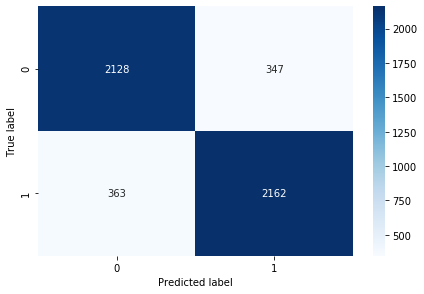

In [133]:
visualize_confusion_matrix(baseline_predicted,test_labels)